Bounding Box: xmin=-141.0033321841923, ymin=41.909180446903044, xmax=-52.807816401875534, ymax=72.95972573830879


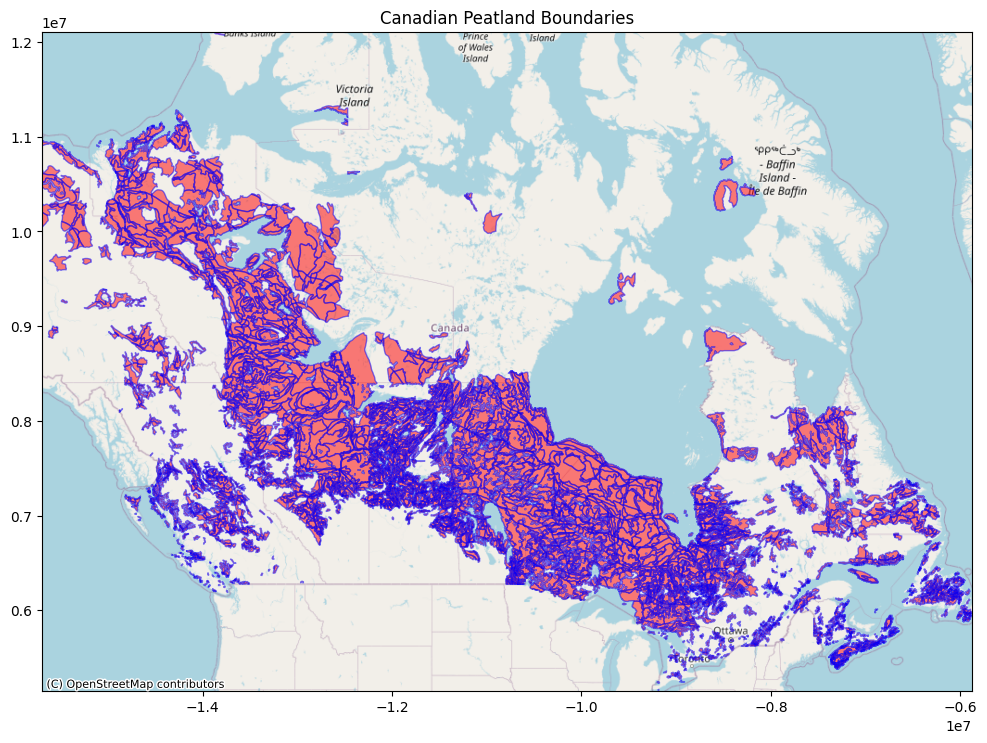

In [6]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, box
import contextily as ctx
import matplotlib.pyplot as plt

# Load peatland polygon shapefile
peatland_gdf = gpd.read_file('./canada_peats/Canada_Peatland.shp')

# Ensure CRS is WGS-84
if peatland_gdf.crs is None:
	peatland_gdf.set_crs(epsg=4326, inplace=True)
else:
	peatland_gdf = peatland_gdf.to_crs(epsg=4326)

# Get bounding box of peatland areas
xmin, ymin, xmax, ymax = peatland_gdf.total_bounds
print(f"Bounding Box: xmin={xmin}, ymin={ymin}, xmax={xmax}, ymax={ymax}")


# Display initial map showing peatland boundaries
fig, ax = plt.subplots(figsize=(12, 12))

# Convert to Web Mercator for plotting
peatland_gdf_web = peatland_gdf.to_crs(epsg=3857)

# Plot the peatland data first
peatland_gdf_web.plot(ax=ax, color='red', edgecolor='blue', alpha=0.5)

# Set the plot limits
ax.set_xlim(peatland_gdf_web.total_bounds[[0,2]])
ax.set_ylim(peatland_gdf_web.total_bounds[[1,3]])

# Add basemap after plotting the data
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Canadian Peatland Boundaries')


plt.show()


In [ ]:
# # Grid size in degrees (approximate for WGS-84, adjust if needed)
# grid_size = 0.0075  # Approximate degrees for 750m (varies by latitude)

# # Generate grid cells
# grid_cells = []
# x_coords = np.arange(xmin, xmax, grid_size)
# y_coords = np.arange(ymin, ymax, grid_size)

# for x in x_coords:
#     for y in y_coords:
#         grid_cells.append(box(x, y, x + grid_size, y + grid_size))

# # Create GeoDataFrame for grid
# grid = gpd.GeoDataFrame(geometry=grid_cells, crs=peatland_gdf.crs)

# # Intersect grid with peatland polygons
# grid_clipped = gpd.overlay(grid, peatland_gdf, how='intersection')

# # Get centroids as sampling points
# grid_points = grid_clipped.centroid
# grid_points_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=peatland_gdf.crs)

# # Save points as GeoJSON or Shapefile
# grid_points_gdf.to_file('./systematic_sampled/systematic_peatland_points.shp')



In [ ]:
import geopandas as gpd
import numpy as np
from shapely.geometry import box, Point
from rtree import index
from multiprocessing import Pool
import pandas as pd

# Load Peatland Shapefile and ensure CRS
peatland_gdf = gpd.read_file('./canada_peats/Canada_Peatland.shp')
if peatland_gdf.crs is None:
    peatland_gdf.set_crs(epsg=4326, inplace=True)
peatland_gdf = peatland_gdf.to_crs(epsg=4326)

# Build R-Tree Spatial Index
spatial_index = index.Index()
for i, geom in enumerate(peatland_gdf.geometry):
    spatial_index.insert(i, geom.bounds)

# Define Systematic Grid Function
def generate_grid(bounds):
    """
    Generate systematic grid points within given bounds and filter using R-Tree.
    """
    xmin, ymin, xmax, ymax = bounds
    grid_size = 0.0075  # Approximate grid size for 750m resolution

    grid_points = []
    for x in np.arange(xmin, xmax, grid_size):
        for y in np.arange(ymin, ymax, grid_size):
            cell = box(x, y, x + grid_size, y + grid_size)
            intersecting_indices = list(spatial_index.intersection(cell.bounds))
            if any(peatland_gdf.iloc[i].geometry.intersects(cell) for i in intersecting_indices):
                grid_points.append(Point(x + grid_size / 2, y + grid_size / 2))

    return grid_points

# Define Bounding Box Chunks
def get_chunks(xmin, ymin, xmax, ymax, step_size):
    """
    Divide bounding box into smaller chunks.
    """
    chunks = []
    for x in np.arange(xmin, xmax, step_size):
        for y in np.arange(ymin, ymax, step_size):
            chunks.append((x, y, x + step_size, y + step_size))
    return chunks

# Get Bounding Box
xmin, ymin, xmax, ymax = peatland_gdf.total_bounds
chunk_size = 1.0  # Divide bounding box into 1° x 1° chunks
chunks = get_chunks(xmin, ymin, xmax, ymax, chunk_size)

# Parallel Processing
def process_chunk(chunk):
    """
    Process each chunk in parallel.
    """
    try:
        points = generate_grid(chunk)
        return points
    except Exception as e:
        print(f"Error in chunk {chunk}: {e}")
        return []

import time
start_time = time.time()

# Use multiprocessing to process chunks in parallel
with Pool(processes=4) as pool:  # Adjust the number based on CPU cores
    results = pool.map(process_chunk, chunks)
    # Combine results into a single GeoDataFrame
    all_points = [pt for sublist in results for pt in sublist]
points_gdf = gpd.GeoDataFrame(geometry=all_points)
points_gdf.set_crs(epsg=4326, inplace=True)

# Extract coordinates for CSV
points_gdf['longitude'] = points_gdf.geometry.x
points_gdf['latitude'] = points_gdf.geometry.y

# Save to File
points_gdf.to_file('./systematic_sampled/systematic_peatland_points.shp')
points_gdf[['longitude', 'latitude']].to_csv('./systematic_sampled/systematic_peatland_points.csv', index=False)
points_gdf.to_file('./systematic_sampled/systematic_peatland_points.shp')
points_gdf[['geometry']].to_csv('./systematic_sampled/systematic_peatland_points.csv', index=False)

end_time = time.time()
print(f"Systematic grid sampling completed in {(end_time - start_time) / 60:.2f} minutes.")


In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

# Convert to Web Mercator for contextily
peatland_gdf_web = peatland_gdf.to_crs(epsg=3857)
ax.set_xlim(peatland_gdf_web.total_bounds[[0,2]])
ax.set_ylim(peatland_gdf_web.total_bounds[[1,3]])

# Add basemap using OpenStreetMap
ctx.add_basemap(ax, crs=peatland_gdf_web.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

peatland_gdf.plot(ax=ax, color='lightblue', edgecolor='k', alpha=0.1)
grid_points_gdf.plot(ax=ax, color='red', markersize=5)



plt.title('Systematic Sampling Points Across Peatlands')
plt.show()




In [ ]:
import seaborn as sns

# Plot density heatmap
fig, ax = plt.subplots(figsize=(12, 12))
sns.kdeplot(
    x=grid_points_gdf['longitude'],
    y=grid_points_gdf['latitude'],
    cmap="Reds",
    fill=True,
    bw_adjust=0.5
)
peatland_gdf.plot(ax=ax, color='none', edgecolor='blue')
plt.title('Density of Systematic Sampling Points')
plt.show()


In [9]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon
import pyproj

# ---------------------------
# 1. Load Shapefile
# ---------------------------
# Path to the input shapefile
input_shapefile = './peatlands/peat032005.shp'
output_shapefile = './peatlands/peatlands_wgs84_valid.shp'

# Load the shapefile
print("Loading shapefile...")
peatlands = gpd.read_file(input_shapefile)
# Rename duplicate columns if they exist
if len(peatlands.columns[peatlands.columns.duplicated()]) > 0:
    # Get list of duplicate columns
    duplicate_cols = peatlands.columns[peatlands.columns.duplicated()].tolist()
    # Rename duplicates by adding a suffix
    for col in duplicate_cols:
        col_indices = peatlands.columns.get_loc(col)
        if isinstance(col_indices, (slice, np.ndarray)):
            # Convert to list if multiple indices
            col_indices = np.where(peatlands.columns == col)[0]
            # Rename all but first occurrence
            for i in col_indices[1:]:
                new_col_name = f"{col}_{i}"
                peatlands.columns.values[i] = new_col_name

# ---------------------------
# 2. Check CRS and Reproject
# ---------------------------
print("Checking CRS...")
if peatlands.crs is None:
    print("No CRS found. Setting to EPSG:4326...")
    peatlands.set_crs(epsg=4326, inplace=True)
elif peatlands.crs != "EPSG:4326":
    print(f"Current CRS: {peatlands.crs}")
    print("Reprojecting to EPSG:4326...")
    peatlands = peatlands.to_crs(epsg=4326)
else:
    print("CRS is already EPSG:4326.")

# ---------------------------
# 3. Validate and Fix Geometries
# ---------------------------
print("Validating geometries...")
peatlands['is_valid'] = peatlands.is_valid

# Fix invalid geometries
if not peatlands['is_valid'].all():
    print("Fixing invalid geometries...")
    peatlands = peatlands.buffer(0)  # Fix geometries by applying a small buffer
    peatlands = gpd.GeoDataFrame(peatlands, geometry='geometry', crs='EPSG:4326')

# Remove invalid geometries entirely (optional step)
peatlands = peatlands[peatlands.is_valid]

# ---------------------------
# 4. Check Coordinate Validity
# ---------------------------
print("Checking coordinate validity...")
# Ensure coordinates are within valid lat/lon ranges
valid_bounds = (-180, -90, 180, 90)  # Longitude (-180 to 180), Latitude (-90 to 90)
peatlands = peatlands.cx[valid_bounds[0]:valid_bounds[2], valid_bounds[1]:valid_bounds[3]]

# ---------------------------
# 5. Save the Clean Shapefile
# ---------------------------
print("Saving the cleaned shapefile...")
peatlands.drop(columns=['is_valid'], errors='ignore', inplace=True)  # Remove temporary column
peatlands.to_file(output_shapefile, driver='ESRI Shapefile')

print(f"✅ Cleaned shapefile saved at: {output_shapefile}")


Loading shapefile...
Checking CRS...
No CRS found. Setting to EPSG:4326...
Validating geometries...
Checking coordinate validity...
Saving the cleaned shapefile...
✅ Cleaned shapefile saved at: ./peatlands/peatlands_wgs84_valid.shp


C:\Users\Rohan\AppData\Local\Temp\ipykernel_37520\2819527731.py:73: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  peatlands.to_file(output_shapefile, driver='ESRI Shapefile')
c:\Users\Rohan\carbon-seq-model\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'PEAT032005_3' to 'PEAT0320_1'
  ogr_write(
